# Basic Project: Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import time 
import numpy as np
from torchvision.transforms import RandAugment
import random 
import PIL


Tic() Toc() Functions to track training time

In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        return time.time() - startTime_for_tictoc
        #print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        

In [3]:
data_root = "datasets"


Download ResNet18

In [4]:
# for ResNet18:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Dataset

In [5]:
trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='binary-category',
        transform=transform,
        download=False
    )
test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types='binary-category',
        transform=transform,
        download=False
    )


Train / Test Dataset Split

In [6]:
val_ratio = 0.2  # 20% for validation
train_size = int((1 - val_ratio) * len(trainval_data))
val_size = len(trainval_data) - train_size

train_data, val_data = random_split(trainval_data, [train_size, val_size])


Visualize 10 random images

Indices: [1397, 2112, 532, 1197, 2220, 2810, 87, 588, 1910, 1654]
Labels: ['Siamese', 'Siamese', 'American Bulldog', 'Samoyed', 'Leonberger', 'Maine Coon', 'Havanese', 'Yorkshire Terrier', 'Scottish Terrier', 'Pug']


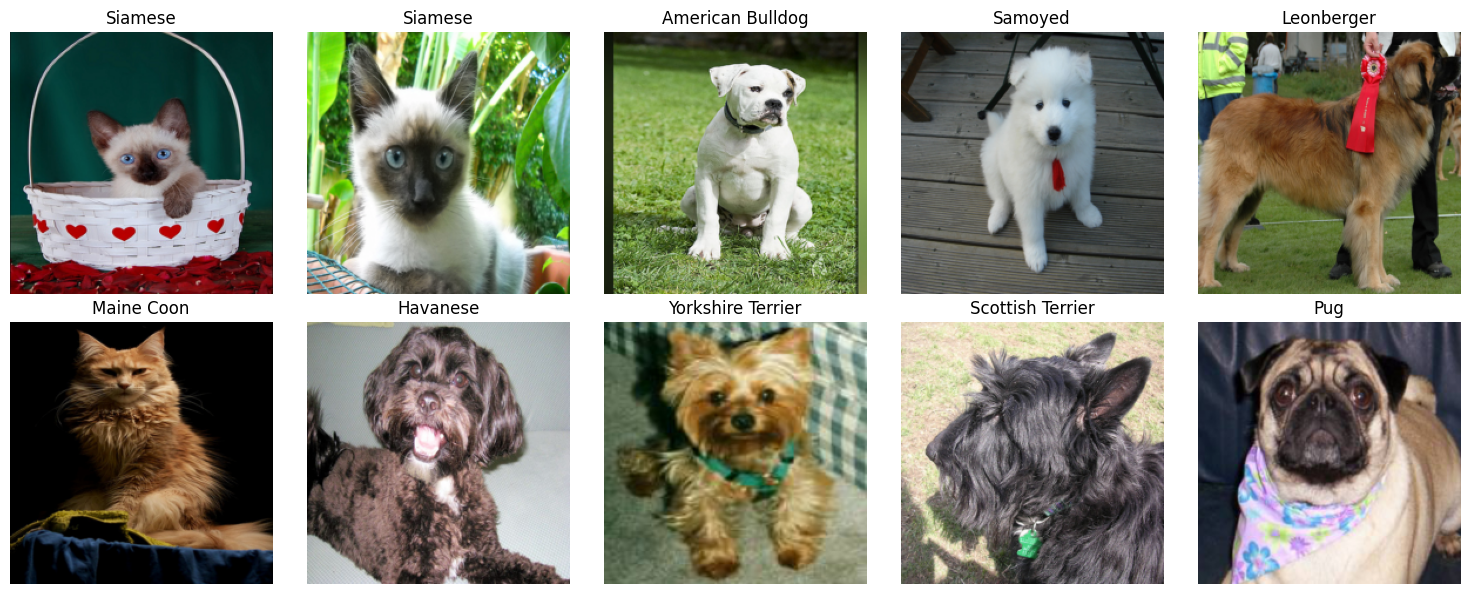

In [ ]:
len(val_data), len(train_data), len(test_data)

visualize_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='category',
        transform=transform,
        download=False
    )
images2vis, _ = random_split(visualize_dataset, [train_size, val_size])

def de_normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if isinstance(img_tensor, tuple):
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.clone() # avoid modifying the original tensor
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def VisImages(data):
    
    # Randomly select 10 indices
    indices = random.sample(range(len(data)), 10)

    # Extract the corresponding images and labels
    images = [de_normalize(data[i][0]) for i in indices]
    labels = [data.dataset.classes[data[i][1]] for i in indices]

    # Convert tensors to PIL images
    images = [F.to_pil_image(img) for img in images]

    # Display the images and labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for ax, img, label in zip(axes.flatten(), images, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{label}")
    plt.tight_layout()
    plt.show()


# Visualize 
VisImages(images2vis)


Data Loaders

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [9]:
dataloaders = {}
dataset_sizes = {}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader
dataloaders['test'] = test_loader

dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)


Initialize the Network

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("If GPU is available: \npip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
    print("Restart the kernel and run the code again.")
    print("Check with `print(torch.cuda.is_available())`")
    print("Documentation: https://pytorch.org/get-started/locally/")
    
# ResNet18
network = models.resnet18(weights='DEFAULT')
nf = network.fc.in_features
network.fc = nn.Linear(nf, 2)
network = network.to(device)


Using device: cuda


Function to Train the Network

In [11]:
def train_network(network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Set Starting Time
    tic()

    with TemporaryDirectory() as tempdir:
        best_network_params_path = os.path.join(tempdir, 'best_network_params.pt')

        torch.save(network.state_dict(), best_network_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    network.train()
                else:
                    network.eval()

                running_loss = 0.0
                running_corrects = 0

                for X, Y in dataloaders[phase]:
                    X = X.to(device)
                    Y = Y.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        S = network(X)
                        _, P = torch.max(S, 1)
                        loss = criterion(S, Y)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * X.size(0)
                    running_corrects += torch.sum(P == Y.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(network.state_dict(), best_network_params_path)

            print()

        print(f'Best val Acc: {best_acc:4f}')

        network.load_state_dict(torch.load(best_network_params_path, weights_only=True))
        
    # Print Time for Training only
    el_time_training = toc()
    print(f"\nTime for training: {el_time_training:.1f} sec.")
    
    # Return Network and Training Statistics
    train_stats = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'elapsed_time': el_time_training,
    }
    
    return network, train_stats
    # return network, train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
def compute_accuracy(network, loader, print_result=True):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            S = network(X)
            _, P = torch.max(S, 1)
            correct += (P == Y).sum().item()
            total += Y.size(0)

    acc = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {acc:.2f}%")
        
    return acc


Define Entropy Criterion and the Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)


Train the Network

In [14]:
# Running for 25 epochs
TrainYN = False
if TrainYN:
    network, train_stats = train_network(
        network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25
    )


Plot the Results

In [15]:
def VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(facecolor='white', figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.grid()
    #plt.show()

    #plt.figure(facecolor='white')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    #plt.ylim([0.9, 1.02])
    plt.title('Accuracy over epochs')
    plt.grid()
    plt.show()
    

# Visualize the loss and accuracy of the Network
if TrainYN:    
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)
    compute_accuracy(network, test_loader)
    

## Multi-Class Problem
- Identifying all 37 breeds of Cats & Dogs

In [16]:
def Load_TrainTestData(data_root, target_types, transform):
    trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=transform,
        download=False
    )

    val_ratio = 0.2  # 20% for validation
    train_size = int((1 - val_ratio) * len(trainval_data))
    val_size = len(trainval_data) - train_size

    train_data, val_data = random_split(trainval_data, [train_size, val_size])
    
    return train_data, val_data, test_data


def DataLoaderFnc(train_data, val_data, test_data, batch_size=32):

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    dataloaders = {}
    dataset_sizes = {}

    dataloaders['train'] = train_loader
    dataloaders['val'] = val_loader
    dataloaders['test'] = test_loader

    dataset_sizes['train'] = len(train_data)
    dataset_sizes['val'] = len(val_data)

    return dataloaders, dataset_sizes


def Initialize_ResNet18(no_target_classes=2):
    
    network = models.resnet18(weights='DEFAULT')
    nf = network.fc.in_features
    network.fc = nn.Linear(nf, no_target_classes)
    network = network.to(device)
    
    return network



In [17]:
TrainYN = False
if TrainYN:
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, 'category', transform)

    # Create DataLoaders
    dataloaders, dataset_sizes = DataLoaderFnc(train_data, val_data, test_data, batch_size=32)

    # Initialize ResNet18
    init_network = Initialize_ResNet18(no_target_classes=37)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr=1e-4)

    # Train the network
    network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=10
    )

    # Visualize the loss and accuracy of the Network
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, test_loader, print_result=True)


Build one big Training Function

In [18]:
def TrainResNet18_S1(data_root, target_types, transform, TrainParams):
    
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    L = TrainParams.get('L', 0)  # Number of layers to fine-tune simultaneously
    strategy = TrainParams['strategy']  # 'fine-tune' or 'un-freeze'
    curr_layer = TrainParams.get('curr_layer', 0)  # Current layer to unfreeze
    InitNetYN = TrainParams.get('InitNetYN', True)  # Initialize network
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes = DataLoaderFnc(train_data, val_data, test_data, batch_size)

    # Initialize ResNet18
    init_network = Initialize_ResNet18(no_target_classes)
    
    # Freeze/Unfreeze Layers
    if strategy == 'fine-tune':
        for l, param in enumerate(init_network.parameters()):
            if l <= L:
                param.requires_grad = True
            else:
                param.requires_grad = False
    elif strategy == 'un-freeze':
        for l, param in enumerate(init_network.parameters()):
            param.requires_grad = False
            if l == curr_layer:
                param.requires_grad = True

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr)

    # Train the network
    network, train_stats = train_network(
        init_network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs
    )

    # Visualize the loss and accuracy of the Network
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, test_loader, print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc
    
    return network, train_stats
    

### Strategy 1: Fine-tune $l$ layers simultaneously

In [19]:
# Layers to unfreeze
layers = [0, 3, 5, 10]

# Training Parameters
TrainParams = {
    'batch_size': 32,
    'num_epochs': 10,
    'no_target_classes': 37,
    'lr': 1e-4,
    'L': 0,  # Unfreeze the last layer
    'strategy': 'fine-tune',  # 'fine-tune' or 'un-freeze'
}


# Loop through the layers and train the network
train_stats_list = []
TrainYN = False
if TrainYN:
    for l in layers:
        print(f"\nTraining with fine-tuning layers up to layer {l}...")
        TrainParams['L'] = l  # Set the number of layers to fine-tune
        _, train_stats_S1 = TrainResNet18_S1(data_root, 'category', transform, TrainParams)
        print(f"Finished training with fine-tuning layers up to layer {l}.")
        train_stats_list.append(train_stats)
    

### Strategy 2: Gradual un-freezing

In [20]:
def TrainResNet18_S2(data_root, target_types, transform, TrainParams):
    
    # Extract Training Parameters
    batch_size = TrainParams.get('batch_size', 32)
    num_epochs = TrainParams.get('num_epochs', 25)
    no_target_classes = TrainParams.get('no_target_classes', 2)
    lr = TrainParams.get('lr', 1e-4)
    
    # Load Train, Validation and Test Data
    train_data, val_data, test_data = Load_TrainTestData(data_root, target_types, transform)

    # Create DataLoaders
    dataloaders, dataset_sizes = DataLoaderFnc(train_data, val_data, test_data, batch_size)

    # Initialize ResNet18
    init_network = Initialize_ResNet18(no_target_classes)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(init_network.parameters(), lr)
    
    # Freeze/Unfreeze Layers
    network = init_network
    list_train_stats = []
    print("\nStart Training Network (Strategy: gradually unfreeze layers) ...")
    # Loop around the layers and train the network
    for layer, _ in enumerate(init_network.parameters()):
        # Freeze / unfreeze the right layers (gradually unfreeze)
        for l, param in enumerate(network.parameters()):
            param.requires_grad = False
            if l == layer: # unfreeze the current layer
                param.requires_grad = True
        # Train the network (only the unfreezed layers)
        print("------------------------------------------")
        print(f"\nTraining with unfreezing layer {layer}...")
        network, train_stats = train_network(
            network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs
        )
        list_train_stats.append(train_stats)


    # Visualize the loss and accuracy of the Network
    train_losses, val_losses, train_accuracies, val_accuracies = \
                train_stats['train_losses'], train_stats['val_losses'], \
                train_stats['train_accuracies'], train_stats['val_accuracies']  
    VisLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies)

    # Print the Accuracy
    final_acc = compute_accuracy(network, test_loader, print_result=True)

    # Add the final accuracy to the training statistics
    train_stats['final_accuracy'] = final_acc
    
    return network, train_stats, list_train_stats
    
    

In [21]:
# Training Parameters
TrainParams['strategy'] = 'un-freeze'

# Train the network with gradually unfreezing layers
TrainYN = False
if TrainYN:
    trained_net_S2, train_stats_S2, list_train_stats = TrainResNet18_S2(data_root, 'category', transform, TrainParams)


## Fine-Tuning with imbalanced classes
- Check the Training behavior with class-imbalance
- Try a strategy (e.g. weighted cross-entropy and/or over-sampling of minority classes) to compensate the imbalanced training set

# Extend basic project --> B/A
- FixMatch
- https://github.com/google-research/fixmatch/blob/master/pseudo_label.py


### Data Augmentation
- weak augmentation
- strong augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2805231].


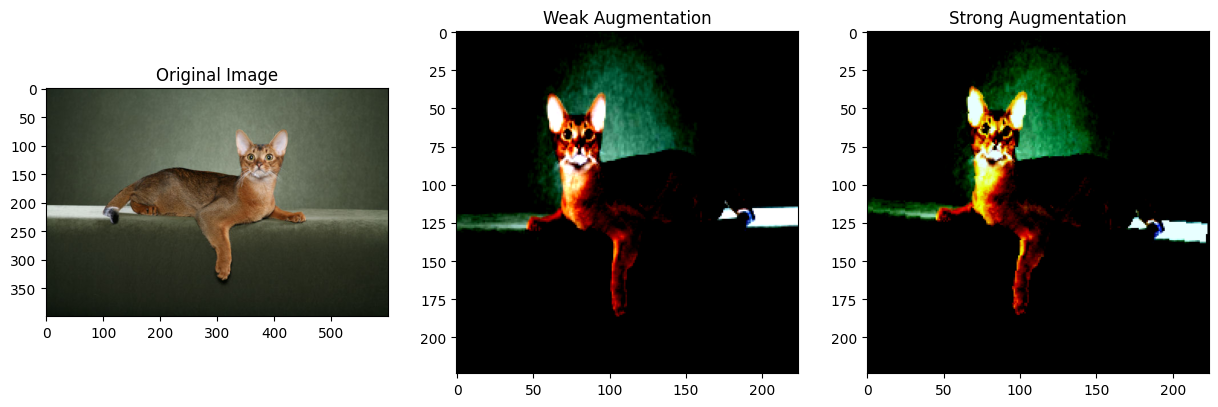

In [22]:
def get_strong_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))], p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.5),
        RandAugment(num_ops=2, magnitude=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_weak_augmentation(image_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet normalization
                             std=[0.229, 0.224, 0.225])
    ])


class TransformFixMatch:
    """Applies weak and strong augmentation to the same input image."""
    def __init__(self, image_size=224):
        self.weak = get_weak_augmentation(image_size)
        self.strong = get_strong_augmentation(image_size)

    def __call__(self, x):
        weak_aug = self.weak(x)
        strong_aug = self.strong(x)
        return weak_aug, strong_aug


# Example usage
transform = TransformFixMatch(image_size=224)
image = PIL.Image.open('datasets/oxford-iiit-pet/images/Abyssinian_1.jpg')
weak_aug, strong_aug = transform(image)
# Visualize the augmentations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.asarray(image))
axes[0].set_title('Original Image')
axes[1].imshow(weak_aug.permute(1, 2, 0).numpy())
axes[1].set_title('Weak Augmentation')
axes[2].imshow(strong_aug.permute(1, 2, 0).numpy())
axes[2].set_title('Strong Augmentation')
plt.show()


Test the TransformFixMatch class (Visualize the Augmentation)

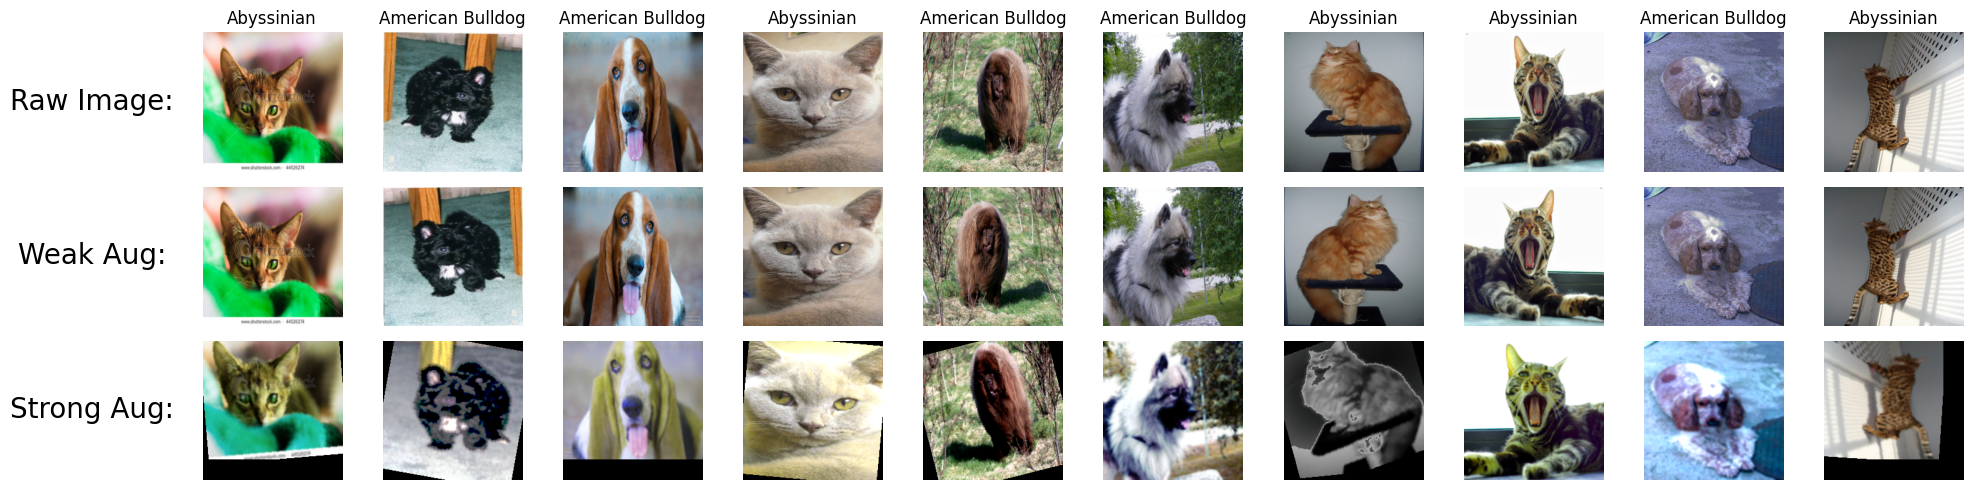

In [23]:
image_size = 224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Define transforms
weak_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
strong_transform = TransformFixMatch(image_size)  # RandAugment included

# Print the transformations
#print("Weak Transformations:", weak_transform)
#print("Strong Transformations:", strong_transform.strong)

# Extract # random pictures from the dataset
no_pictures = 10
ran_indices = random.sample(range(len(trainval_data)), no_pictures)

# Extract the images and labels
ran_images = [de_normalize(trainval_data[i][0]) for i in ran_indices]
labels = [trainval_data.classes[trainval_data[i][1]] for i in ran_indices]
images_raw = [F.to_pil_image(img) for img in ran_images]


# Apply the transformations to the dataset
images_weakaug = [de_normalize(weak_transform(img)) for img in images_raw]
images_weakaug = [F.to_pil_image(img) for img in images_weakaug]
images_strongaug = [de_normalize(strong_transform(img)[1]) if isinstance(strong_transform(img), tuple) \
    else strong_transform(img) for img in images_raw]
images_strongaug = [F.to_pil_image(img) for img in images_strongaug]

# Visualize the weak and strong augmentations
fig, axes = plt.subplots(3, no_pictures+1, figsize=(20, 5))  # 3 rows, 6 columns (1 for labels, 5 for images)

# Add row labels
row_labels = ["Raw Image:", "Weak Aug:", "Strong Aug:"]
for row, label in enumerate(row_labels):
    axes[row, 0].text(0.5, 0.5, label, fontsize=20, ha='center', va='center')
    axes[row, 0].axis('off')

# Add images and headers
for col, (raw, weak, strong, label) in enumerate(zip(images_raw, images_weakaug, images_strongaug, labels), start=1):
    # First row: raw images with headers
    axes[0, col].imshow(raw)
    axes[0, col].set_title(label, fontsize=12)
    axes[0, col].axis('off')

    # Second row: weak augmentations
    axes[1, col].imshow(weak)
    axes[1, col].axis('off')

    # Third row: strong augmentations
    axes[2, col].imshow(strong)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()


### Perpare the Dataset
- Split labelled / unlabelled dataset

In [24]:
def split_labeled_unlabeled(dataset, num_labels_per_class, num_classes, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set random seed for reproducibility
    
    # Access the labels
    try:
        targets = np.array(dataset.targets)  # Use targets attribute if available
    except AttributeError:
        targets = np.array([dataset[i][1] for i in range(len(dataset))])  # Fallback to accessing each sample
    
    labeled_indices = []
    unlabeled_indices = []
    
    for class_idx in range(num_classes):
        class_indices = np.where(targets == class_idx)[0]
        if len(class_indices) < num_labels_per_class:
            raise ValueError(f"Class {class_idx} has fewer samples than num_labels_per_class.")
        
        np.random.shuffle(class_indices)
        labeled_indices.extend(class_indices[:num_labels_per_class])
        unlabeled_indices.extend(class_indices[num_labels_per_class:])
    
    return np.array(labeled_indices), np.array(unlabeled_indices)


def load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeld=32, batch_size_unlabeld=64, image_size=224):
    # Common normalization values for ImageNet (can fine-tune later)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
        
    # Define transforms
    transform_FixMatch = TransformFixMatch(image_size)
    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        normalize
    ])
        
    
    # Load the full dataset
    full_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types=target_types,
        transform=transform,
        download=False
    )
    
    test_dataset = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types=target_types,
        transform=val_test_transform,
        download=False
    )
    
    # Split into labeled and unlabeled data
    labeled_indices, unlabeled_indices = split_labeled_unlabeled(full_dataset, num_labels_per_class, num_classes)
    
    # Create labeled and unlabeled datasets
    labeled_dataset = Subset(full_dataset, labeled_indices)
    unlabeled_dataset = Subset(full_dataset, unlabeled_indices)
    
    # Apply transforms
    labeled_dataset.dataset.transform = transform_FixMatch.weak # Use only weak augmentation for labeled data
    unlabeled_dataset.dataset.transform = transform_FixMatch    # Use both weak and strong augmentations for unlabeled data
    
    # Optional: make a validation split out of labeled set
    val_ratio = 0.2
    val_size = int(val_ratio * len(labeled_dataset))
    train_size = len(labeled_dataset) - val_size
    labeled_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])
    
    # Dictionary to hold DataLoaders
    dataloaders = {
        'labeled': DataLoader(labeled_dataset, batch_size=batch_size_labeld, shuffle=True),
        'unlabeled': DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeld, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size_labeld, shuffle=False),
        'test': DataLoader(test_dataset, batch_size=batch_size_labeld, shuffle=False)
    }
    
    return dataloaders


### Loss Function

In [25]:
def compute_fixmatch_loss(logits_x, targets_x, logits_u_w, logits_u_s, threshold=0.95, lambda_u=1.0):

    
    # Supervised loss
    criterion = nn.CrossEntropyLoss(reduction='mean')
    loss_x = criterion(logits_x, targets_x)
    
    # Generate pseudo labels from weakly augmented unlabeled data
    pseudo_labels = torch.softmax(logits_u_w, dim=-1)
    max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
    
    # Mask to select high-confidence pseudo-labels
    mask = max_probs.ge(threshold).float()
    
    # Unsupervised loss (only for confident predictions)
    unsupervised_criterion = nn.CrossEntropyLoss(reduction='none')
    loss_u = (unsupervised_criterion(logits_u_s, targets_u) * mask).mean()
    
    # Total loss
    total_loss = loss_x + lambda_u * loss_u
    
    return total_loss, loss_x, loss_u


### Training Loop

In [26]:
def train_fixmatch(model, labeled_loader, unlabeled_loader, optimizer, device, epoch, lambda_u=1.0, threshold=0.95):
    model.train()

    # Track losses
    running_loss = 0.0
    running_supervised_loss = 0.0
    running_unsupervised_loss = 0.0

    unlabeled_iter = iter(unlabeled_loader)

    for batch_idx, (inputs_x_ws, targets_x) in enumerate(labeled_loader):
        try:
            # Correctly unpack the unlabeled data
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch  # Unpack images and ignore labels
            inputs_u_w, inputs_u_s = inputs_u  # Unpack weak and strong augmentations
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            unlabeled_batch = next(unlabeled_iter)
            inputs_u, _ = unlabeled_batch
            inputs_u_w, inputs_u_s = inputs_u

        # Move data to device (GPU or CPU)
        inputs_x, _ = inputs_x_ws # Unpack images (weak and strong augmentations) - Size: [batch_size, 3, 224, 224]
        inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
        inputs_u_w, inputs_u_s = inputs_u_w.to(device), inputs_u_s.to(device)

        # Get batch size
        batch_size = inputs_x.size(0)

        # Forward pass
        logits_x = model(inputs_x)
        logits_u_w = model(inputs_u_w)
        logits_u_s = model(inputs_u_s)

        # Compute FixMatch loss
        total_loss, loss_x, loss_u = compute_fixmatch_loss(
            logits_x, targets_x, logits_u_w, logits_u_s,
            threshold=threshold, lambda_u=lambda_u
        )

        # Optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Statistics
        running_loss += total_loss.item()
        running_supervised_loss += loss_x.item()
        running_unsupervised_loss += loss_u.item()

        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx}] "
                  f"Loss: {total_loss.item():.4f} "
                  f"Supervised Loss: {loss_x.item():.4f} "
                  f"Unsupervised Loss: {loss_u.item():.4f}")

    epoch_loss = running_loss / len(labeled_loader)
    epoch_supervised_loss = running_supervised_loss / len(labeled_loader)
    epoch_unsupervised_loss = running_unsupervised_loss / len(labeled_loader)

    return epoch_loss, epoch_supervised_loss, epoch_unsupervised_loss


### Evaluation

In [27]:
def accuracy(output, target, topk=(1,5)):
    """Computes the top-k accuracy"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # Top-k predictions
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def evaluate(model, dataloader, device):
    model.eval()
    
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            if isinstance(inputs, list):
                inputs = inputs[0]
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # Compute top-k accuracies
            top1, top5 = accuracy(outputs, targets, topk=(1, 5))
            
            top1_correct += top1.item() * inputs.size(0) / 100.0
            top5_correct += top5.item() * inputs.size(0) / 100.0
            total += inputs.size(0)
    
    top1_acc = 100.0 * top1_correct / total
    top5_acc = 100.0 * top5_correct / total

    print(f"Validation Top-1 Accuracy: {top1_acc:.2f}% | Top-5 Accuracy: {top5_acc:.2f}%")
    
    return top1_acc, top5_acc


Function to Visualize images from Dataloaders (for debugging)

In [28]:
# Visualize a batch of images
def visualize_dataloader(dataloader, num_images=8):
    # Get a batch of data
    images, labels = next(iter(dataloader))
    
    # Extract images and labels
    print(f"Type of images: {type(images)}")
    print(f"Type of labels: {type(labels)}")
    if isinstance(images, list):
        images = images[0]  # Use only the weakly augmented images
    
    # Create a grid of images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = de_normalize(images[i])
        axes[i].imshow(img.permute(1, 2, 0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f"Label: {labels[i].item()}")
    plt.show()


### Full Training Script

In [29]:
# Configuration
data_root = "datasets"
target_types = 'category'
num_classes = 37  # Pet dataset (all breeds)
num_labels_per_class = 40  # Number of labeled samples per class
image_size = 224
batch_size_labeled = 32
batch_size_unlabeled = batch_size_labeled*5 # 5x more than labeled, typical for FixMatch
num_epochs = 10
threshold = 0.95
lambda_u = 1.0  # weight for unlabeled loss
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = Initialize_ResNet18(num_classes)  # 37 classes for pet breeds

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

# Data Loaders
dataloaders = load_train_val_test_data(data_root, target_types, transform, num_labels_per_class, num_classes, batch_size_labeled, batch_size_unlabeled, image_size)
labeled_loader = dataloaders['labeled']
unlabeled_loader = dataloaders['unlabeled']
validation_loader = dataloaders['val']
test_loader = dataloaders['test']

# Visualize images from the Dataloaders
debugYN = False
if debugYN:
    print("\n--- Labeled Data ---")
    visualize_dataloader(dataloaders['labeled'], 10)
    print("\n--- Unlabeled Data ---")
    visualize_dataloader(dataloaders['unlabeled'], 10)
    print("\n--- Validation Data ---")
    visualize_dataloader(dataloaders['val'], 10)
    print("\n--- Test Data ---")
    visualize_dataloader(dataloaders['test'], 10)


# Training Loop
best_top1 = 0.0
for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")

    # Train
    train_loss, train_supervised_loss, train_unsupervised_loss = train_fixmatch(
        model, labeled_loader, unlabeled_loader, optimizer, device, epoch,
        lambda_u=lambda_u, threshold=threshold
    )

    print(f"Train Loss: {train_loss:.4f} | Supervised: {train_supervised_loss:.4f} | Unsupervised: {train_unsupervised_loss:.4f}")

    # Evaluate
    val_top1, val_top5 = evaluate(model, validation_loader, device)

    # Save best model
    if val_top1 > best_top1:
        best_top1 = val_top1
        torch.save(model.state_dict(), "best_fixmatch_model.pth")
        print("Saved new best model!")
    else:
        print("No improvement, not saving model.")        
        
    

KeyboardInterrupt: 